In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import utime
from tqdm import tqdm
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, accuracy_score
import seaborn as sns

from pathlib import Path
from scipy.signal import decimate
from sleeplab_format import reader

In [2]:
basedir = Path('/main/home/matiasrus@sleep.ru.is/SLF-data/dod_extracted')
ds_name = 'dod'
series_name = 'dodh'
ds_dir = basedir / ds_name
model_path = '/main/collaboration/sas_scoring_models/best_model_20230417_133447/'
save_path = '/main/home/matiasrus@sleep.ru.is/aSAGA_validation/pred_results/dodh/'

In [3]:
def show_confusion_matrix(validations, predictions, labels, title, fontsize):
    """ Plots a confusion matrix using seaborn"""
    matrix = confusion_matrix(validations, predictions)
    matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(figsize=(6,6))
    plt.axes().set_aspect('equal')
    #sns.set(font_scale=0)
    sns.heatmap(matrix,
                cmap="YlGnBu",
                vmin=0, 
                vmax=1,
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt=".2f",
               cbar=False,
               annot_kws={"size":18})
    sns.set(font_scale=1.4)
    acc = accuracy_score(validations, predictions)
    plt.title(title + ", accuracy = " + str(round(acc*100)) + "%", fontsize=fontsize)
    plt.ylabel("Manual sleep staging", fontsize=fontsize)
    plt.xlabel("Automatic sleep staging", fontsize=fontsize)
    plt.show()

In [4]:
# Load model
model = tf.keras.saving.load_model(model_path, compile=False)

2023-05-29 10:05:05.243240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-29 10:05:05.279471: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
# Read dataset and predict
ds = reader.read_dataset(ds_dir)
series = ds.series[series_name]

hg_true_all = []
hg_pred_all = []
hypno_all = []

for subject_id in tqdm(list(series.subjects.keys())):
    subj = series.subjects[subject_id]
    hg_true = []
    
    # True hypnogram
    for ann in subj.annotations['hypnogram'].annotations:
        if ann.name == 'WAKE':
            hg_true.append(0)
        if ann.name == 'N1':
            hg_true.append(1)
        if ann.name == 'N2':
            hg_true.append(2)
        if ann.name == 'N3':
            hg_true.append(3)
        if ann.name == 'REM':
            hg_true.append(4)
    
    # Predict hypnogram
    hypnodensities = np.zeros((len(hg_true),5,len(list(subj.sample_arrays.keys()))))
    
    # Ensemble prediction over all preprocessed channels
    for i, ch_name in enumerate(list(subj.sample_arrays.keys())):
        inputs = {
        'C4': subj.sample_arrays[ch_name].values_func()[np.newaxis, 0:int(len(hg_true)*64*30)]
        }
        outputs = model(inputs).numpy()
        hypnodensities[:,:,i] = outputs[0, ...]
        inputs.clear()
    
    hypno_all.append(hypnodensities)
    hg_true_all.append(hg_true)
    hg_pred_all.append(np.argmax(np.sum(hypnodensities, axis = 2), axis=1))
    

100%|██████████| 25/25 [16:41<00:00, 40.05s/it]


In [6]:
def flatten(l):
    return [item for sublist in l for item in sublist]

hg_true_flat = np.array(flatten(hg_true_all))
hg_pred_flat = np.array(flatten(hg_pred_all))

In [7]:
print(classification_report(hg_true_flat,hg_pred_flat))
print('Kappa: ' + str(cohen_kappa_score(hg_true_flat,hg_pred_flat)))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      3037
           1       0.71      0.29      0.41      1505
           2       0.83      0.83      0.83     11879
           3       0.65      0.97      0.78      3514
           4       0.87      0.78      0.82      4727

    accuracy                           0.80     24662
   macro avg       0.79      0.73      0.73     24662
weighted avg       0.81      0.80      0.79     24662

Kappa: 0.7097786762313251


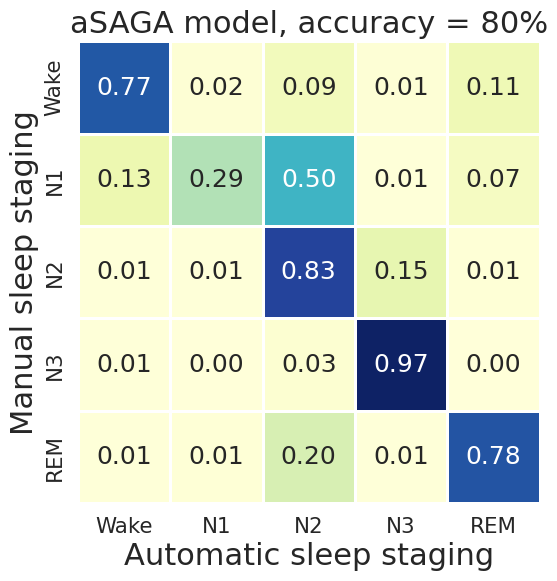

In [10]:
LABELS = ["Wake", "N1", "N2", "N3", "REM"]
fontsize=22
title = 'aSAGA model'

show_confusion_matrix(hg_true_flat, hg_pred_flat, LABELS, title, fontsize)

In [11]:
np.save(save_path + 'hg_true_all', np.array(hg_true_all,dtype=object))
np.save(save_path + 'hg_pred_all', np.array(hg_pred_all,dtype=object))
np.save(save_path + 'hypno_all', np.array(hypno_all,dtype=object))

In [ ]:
hg_tru = np.load(save_path + 'hg_true_all.npy', allow_pickle=True)
hg_pre = np.load(save_path + 'hg_pred_all.npy', allow_pickle=True)